### Predict disease phenotype using ceRNA axis

#### Load the SCZ data

In [59]:
%load_ext autoreload

import scanpy as sc
import anndata as ad

lncRNA_adata = sc.read_h5ad('../../demo/lncRNA_adata.h5ad')
lncRNA_adata.var_names_make_unique()

miRNA_adata = sc.read_h5ad('../../demo/miRNA_adata.h5ad')
miRNA_adata.var_names_make_unique()

mRNA_adata = sc.read_h5ad('../../demo/mRNA_adata.h5ad')
mRNA_adata.var_names_make_unique()

adata = ad.concat([mRNA_adata, miRNA_adata, lncRNA_adata], axis=1)
adata.obs = mRNA_adata.obs
adata.layers['count'] = adata.X
adata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/chenlingxi/miniconda3/envs/dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11 × 80573
    obs: 'type'
    layers: 'count'

#### Predict the phenotype from ceRNA axis

---[INFO]: 33.33% (n=22)/(2*3*11) of entries has non-zero overlap ratio.



/Users/chenlingxi/Library/CloudStorage/Dropbox/workspace/SCZ/CERNATAX/docs/tutorial/../../../../1_GREA/grea/bipolar_profiler.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = perf_df.apply(lambda x: np.sum(x[1:] >= x[0]) / len(x[1:]), axis=0)


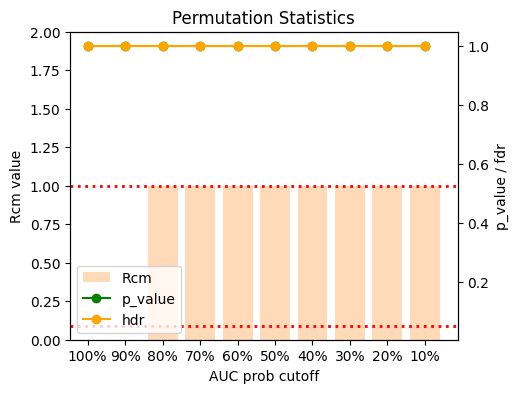

In [60]:
%autoreload
import sys

sys.path.append('../../../../1_GREA')
sys.path.append('../../')

from cernatax.cernatax import CERNATAX

# initialize CERNATAX object
cernatax = CERNATAX()
miRNA_list = ['hsa-miR-485-5p']
ceRNA_list = ['ARHGAP8', 'ENST00000522525']
auc_df, stat_df, perf_df, pred_df = cernatax.pred_pheno(adata, miRNA_list, ceRNA_list)

#### Plot the prediction

/var/folders/0x/6vsm66sd6g3_gc636v4617km0000gn/T/ipykernel_39898/12051117.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(auc_df.index, rotation=45, ha='right')


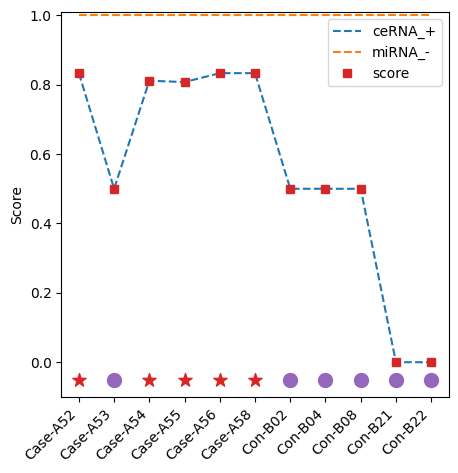

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 2) Set up the figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

p1, = ax.plot(auc_df.index, auc_df["ceRNA_+"], '--', color="C0", label="ceRNA_+")
p2, = ax.plot(auc_df.index, auc_df["miRNA_-"], '--', color="C1", label="miRNA_-")
p3, = ax.plot(auc_df.index, auc_df["Combined"], linestyle='None', marker='s', color="C3", label="score")
ax.set_ylim(-0.1, 1.01)
ax.set_ylabel("Score")
ax.set_xticklabels(auc_df.index, rotation=45, ha='right')

# prediction markers at y = –0.05
x = np.arange(len(auc_df))
y_pred = np.full_like(x, -0.05, dtype=float)
# ★ for Case, ● for Con
markers = pred_df.map({"Case":"*", "Con":"o"}).values
pred_color = pred_df.map({"Case":"C3", "Con":"C4"})
colors  = pred_color.values
for xi, yi, mk, col in zip(x, y_pred, markers, colors):
    ax.scatter([xi], [yi], marker=mk, c=col, s=100, zorder=5)

legend_lines = [p1, p2, p3,
    plt.Line2D([0],[0], marker='*', color='w', markerfacecolor='C3', markersize=10, label='pred=Case'),
    plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='C4', markersize=6,  label='pred=Con'),
]
plt.legend()
fig.savefig('../../demo_out/pred_score.pdf', format='pdf')

We plotted the prediction scores for each sample as follows:

- The blue dashed line represents the predicted probabilities of the ceRNAs (`ARHGAP8` and `ENST00000522525`) being highly expressed.
- The orange dashed line indicates the predicted probabilities of the miRNA (`hsa-miR-485-5p`) being lowly expressed.
- The red rectangular dot shows the combined probability of a sample being an SCZ patient (i.e., exhibiting both high ceRNA and low miRNA expression).

At the bottom of the plot,
- A red star denotes samples predicted as SCZ cases,
- While a purple circle indicates samples predicted as normal controls.

#### Evaluation - the ROC and PR curves of the predicted combined scores


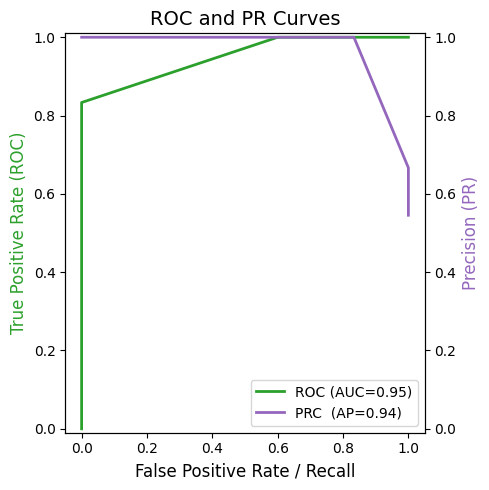

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

mymap = {'Case': 1, 'Con': 0}
actual = np.array([ mymap[x.split('-')[0]] for x in pred_df.index ])
scores = auc_df['Combined']

fig, ax_roc = plt.subplots(figsize=(5,5))
ax_pr  = ax_roc.twinx()   # share the same x‐axis

fpr, tpr, _ = roc_curve(actual, scores)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(actual, scores)
prc_auc = average_precision_score(actual, scores)

ax_roc.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.2f})", lw=2, color='C2')
ax_pr.plot(recall, precision, label=f"PR  (AP={prc_auc:.2f})", lw=2, color='C4')

ax_roc.set_xlabel("False Positive Rate / Recall", fontsize=12)
ax_roc.set_ylabel("True Positive Rate (ROC)", color='C2', fontsize=12)
ax_pr .set_ylabel("Precision (PR)",      color='C4', fontsize=12)

ax_roc.set_ylim(-0.01, 1.01)
ax_pr.set_ylim(-0.01, 1.01)

lines_roc, labels_roc = ax_roc.get_legend_handles_labels()
lines_pr,  labels_pr  = ax_pr .get_legend_handles_labels()
ax_roc.legend(lines_roc + lines_pr,
              labels_roc + labels_pr,
              loc='lower right',
              fontsize=10)

plt.title("ROC and PR Curves", fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig('../../demo_out/pred_curve.pdf', format='pdf')

The plot displays the Receiver Operating Characteristic (ROC) and Precision-Recall (PR) curves for the predicted combined probabilities of each sample being SCZ or not, compared to the ground truth labels. The green curve represents the ROC, with an area under the curve (AUC) of 0.95, while the purple curve shows the PR curve, with an average precision (AP) of 0.94. Both metrics indicate that the mRNA-miRNA-lncRNA triplet (`ARHGAP8`, `hsa-miR-485-5p`, `ENST00000522525`) has strong discriminative power as a marker for SCZ.

#### Evaluation - the F1-score, accuracy, recall and precision of the predicted phenotype label (case vs. control)

In [69]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
mymap = {'Case': 1, 'Con':0}
actual = [mymap[x.split('-')[0]] for x in pred_df.index]
res = []
pred = pred_df.apply(lambda x: mymap[x])
acc = accuracy_score(actual, pred)
f1 = f1_score(actual, pred)
recall = recall_score(actual, pred)
precision = precision_score(actual, pred)
res.append([acc, f1, recall, precision])
df = pd.DataFrame(res, columns=['ACC', 'F1-Score', 'Recall', 'Precision']).T
df = df.reset_index()
df.columns = ['metric', 'value']
print(pred_df)
df

Case-A52    Case
Case-A53     Con
Case-A54    Case
Case-A55    Case
Case-A56    Case
Case-A58    Case
Con-B02      Con
Con-B04      Con
Con-B08      Con
Con-B21      Con
Con-B22      Con
Name: prob_80%, dtype: object


,metric,value
0,ACC,0.909091
1,F1-Score,0.909091
2,Recall,0.833333
3,Precision,1.000000


The results show that the predicted labels (case or control) of the mRNA–miRNA–lncRNA triplet (`ARHGAP8`, `hsa-miR-485-5p`, `ENST00000522525`) differ from the ground truth for only one sample `Case-A53`.

#### Plot the evaluation metrics

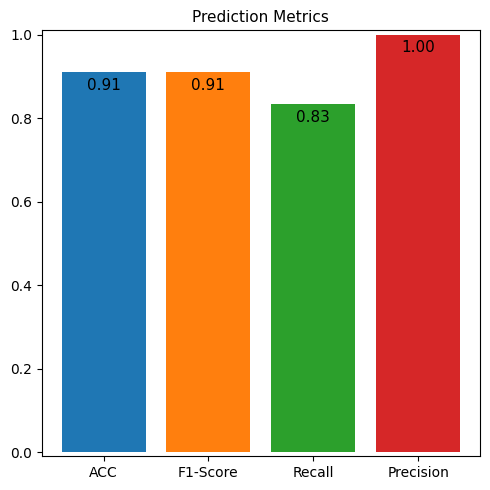

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

scores, values = df.metric, df.value
bars = ax.bar(scores, values, color=['C0','C1','C2','C3'])

for bar, val in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        val - 0.05,            
        f"{val:.2f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

ax.set_ylim(-0.01, 1.01)
ax.set_title("Prediction Metrics", fontsize=11)
plt.tight_layout()
plt.show()
fig.savefig('../../demo_out/pred_metric.pdf', format='pdf')

We evaluated the performance of the mRNA–miRNA–lncRNA triplet (`ARHGAP8`, `hsa-miR-485-5p`, `ENST00000522525`) by comparing its predicted labels (case or control) against the ground truth for each sample. The results show an accuracy (ACC) of 0.91, F1-score of 0.91, recall of 0.83, and precision of 1. These metrics further demonstrate that the ceRNA triplet possesses strong discriminative power as a marker for SCZ.